In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import fashion_mnist

# Load the MNIST data.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# If subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Input image dimensions.
input_shape = x_train.shape[1:]

Using TensorFlow backend.


The depth of the network can be changed with parameter n.
The fuzzy classifier can be changed with the use_anfis parameter.

In [2]:
from keras.layers import *
from model import LogGaussMF
from resnet_backend import *


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', 4. * lr)
    return 4. * lr


# Prepare model model saving directory.
def get_callbacks(model_type):
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = "%s_model.{epoch:03d}.h5" % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)

    # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(
        factor=np.sqrt(0.1),
        cooldown=0,
        patience=5,
        min_lr=0.5e-6)

    return [checkpoint, lr_reducer, lr_scheduler]


use_anfis = True

n = 6
depth = n * 9 + 2

# Model name, depth and version
model_type = 'Fuzzy-ResNet%dv%d' % (depth, 2)

inputs, features = resnet_backend_v2(
    input_shape=input_shape, 
    depth=depth)

memberships = LogGaussMF(10)(features)
rules = Lambda(lambda x: K.sum(x, axis=-1))(memberships)

if use_anfis:
    linear = Dense(10)(features)
    logits = Add()([rules, linear])
else:
    logits = rules

outputs = Activation("softmax")(logits)
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=lr_schedule(0)),
    metrics=['accuracy'])

callbacks = get_callbacks(model_type)

W0413 13:45:09.258332 140026519725888 deprecation.py:506] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Learning rate:  0.004


In [3]:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=128),
    steps_per_epoch=60000 // 128,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

Epoch 1/200
Learning rate:  0.004
468/468 [==============================] - 58s 125ms/step - loss: 1.0918 - acc: 0.7703 - val_loss: 0.7969 - val_acc: 0.8072

Epoch 00001: val_acc improved from -inf to 0.80720, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet56v2_model.001.h5
Epoch 2/200
Learning rate:  0.004
468/468 [==============================] - 46s 99ms/step - loss: 0.6845 - acc: 0.8278 - val_loss: 0.8027 - val_acc: 0.7820

Epoch 00002: val_acc did not improve from 0.80720
Epoch 3/200
Learning rate:  0.004
468/468 [==============================] - 47s 100ms/step - loss: 0.6006 - acc: 0.8469 - val_loss: 1.4112 - val_acc: 0.5759

Epoch 00003: val_acc did not improve from 0.80720
Epoch 4/200
Learning rate:  0.004
468/468 [==============================] - 47s 100ms/step - loss: 0.5586 - acc: 0.8546 - val_loss: 0.6523 - val_acc: 0.8215

Epoch 00004: val_acc improved from 0.80720 to 0.82150, saving model to /home/ryan-desktop/Documen

468/468 [==============================] - 44s 94ms/step - loss: 0.3532 - acc: 0.9043 - val_loss: 0.6262 - val_acc: 0.8204

Epoch 00036: val_acc did not improve from 0.89020
Epoch 37/200
Learning rate:  0.004
468/468 [==============================] - 44s 94ms/step - loss: 0.3524 - acc: 0.9050 - val_loss: 0.4139 - val_acc: 0.8882

Epoch 00037: val_acc did not improve from 0.89020
Epoch 38/200
Learning rate:  0.004
468/468 [==============================] - 44s 93ms/step - loss: 0.3503 - acc: 0.9040 - val_loss: 0.6698 - val_acc: 0.7990

Epoch 00038: val_acc did not improve from 0.89020
Epoch 39/200
Learning rate:  0.004
468/468 [==============================] - 44s 93ms/step - loss: 0.3494 - acc: 0.9052 - val_loss: 0.6408 - val_acc: 0.8120

Epoch 00039: val_acc did not improve from 0.89020
Epoch 40/200
Learning rate:  0.004
468/468 [==============================] - 44s 94ms/step - loss: 0.3480 - acc: 0.9049 - val_loss: 0.5073 - val_acc: 0.8477

Epoch 00040: val_acc did not improve fro

468/468 [==============================] - 44s 94ms/step - loss: 0.2068 - acc: 0.9431 - val_loss: 0.2469 - val_acc: 0.9318

Epoch 00110: val_acc did not improve from 0.93280
Epoch 111/200
Learning rate:  0.0004
468/468 [==============================] - 44s 94ms/step - loss: 0.2035 - acc: 0.9423 - val_loss: 0.2417 - val_acc: 0.9325

Epoch 00111: val_acc did not improve from 0.93280
Epoch 112/200
Learning rate:  0.0004
468/468 [==============================] - 44s 94ms/step - loss: 0.2013 - acc: 0.9452 - val_loss: 0.2406 - val_acc: 0.9316

Epoch 00112: val_acc did not improve from 0.93280
Epoch 113/200
Learning rate:  0.0004
468/468 [==============================] - 44s 94ms/step - loss: 0.2021 - acc: 0.9432 - val_loss: 0.2444 - val_acc: 0.9321

Epoch 00113: val_acc did not improve from 0.93280
Epoch 114/200
Learning rate:  0.0004
468/468 [==============================] - 44s 93ms/step - loss: 0.2030 - acc: 0.9437 - val_loss: 0.2550 - val_acc: 0.9274

Epoch 00114: val_acc did not imp

468/468 [==============================] - 44s 93ms/step - loss: 0.1803 - acc: 0.9500 - val_loss: 0.2312 - val_acc: 0.9364

Epoch 00145: val_acc did not improve from 0.93700
Epoch 146/200
Learning rate:  4e-05
468/468 [==============================] - 44s 94ms/step - loss: 0.1782 - acc: 0.9511 - val_loss: 0.2308 - val_acc: 0.9361

Epoch 00146: val_acc did not improve from 0.93700
Epoch 147/200
Learning rate:  4e-05
468/468 [==============================] - 44s 94ms/step - loss: 0.1823 - acc: 0.9492 - val_loss: 0.2288 - val_acc: 0.9361

Epoch 00147: val_acc did not improve from 0.93700
Epoch 148/200
Learning rate:  4e-05
468/468 [==============================] - 45s 96ms/step - loss: 0.1788 - acc: 0.9509 - val_loss: 0.2297 - val_acc: 0.9366

Epoch 00148: val_acc did not improve from 0.93700
Epoch 149/200
Learning rate:  4e-05
468/468 [==============================] - 44s 94ms/step - loss: 0.1781 - acc: 0.9509 - val_loss: 0.2295 - val_acc: 0.9371

Epoch 00149: val_acc improved from 0


Epoch 00183: val_acc did not improve from 0.93710
Epoch 184/200
Learning rate:  2e-06
468/468 [==============================] - 44s 95ms/step - loss: 0.1756 - acc: 0.9511 - val_loss: 0.2288 - val_acc: 0.9367

Epoch 00184: val_acc did not improve from 0.93710
Epoch 185/200
Learning rate:  2e-06
468/468 [==============================] - 44s 94ms/step - loss: 0.1752 - acc: 0.9511 - val_loss: 0.2288 - val_acc: 0.9367

Epoch 00185: val_acc did not improve from 0.93710
Epoch 186/200
Learning rate:  2e-06
468/468 [==============================] - 45s 95ms/step - loss: 0.1760 - acc: 0.9513 - val_loss: 0.2289 - val_acc: 0.9369

Epoch 00186: val_acc did not improve from 0.93710
Epoch 187/200
Learning rate:  2e-06
468/468 [==============================] - 44s 94ms/step - loss: 0.1744 - acc: 0.9526 - val_loss: 0.2288 - val_acc: 0.9367

Epoch 00187: val_acc did not improve from 0.93710
Epoch 188/200
Learning rate:  2e-06
468/468 [==============================] - 45s 95ms/step - loss: 0.1778 -

NameError: name 'history' is not defined

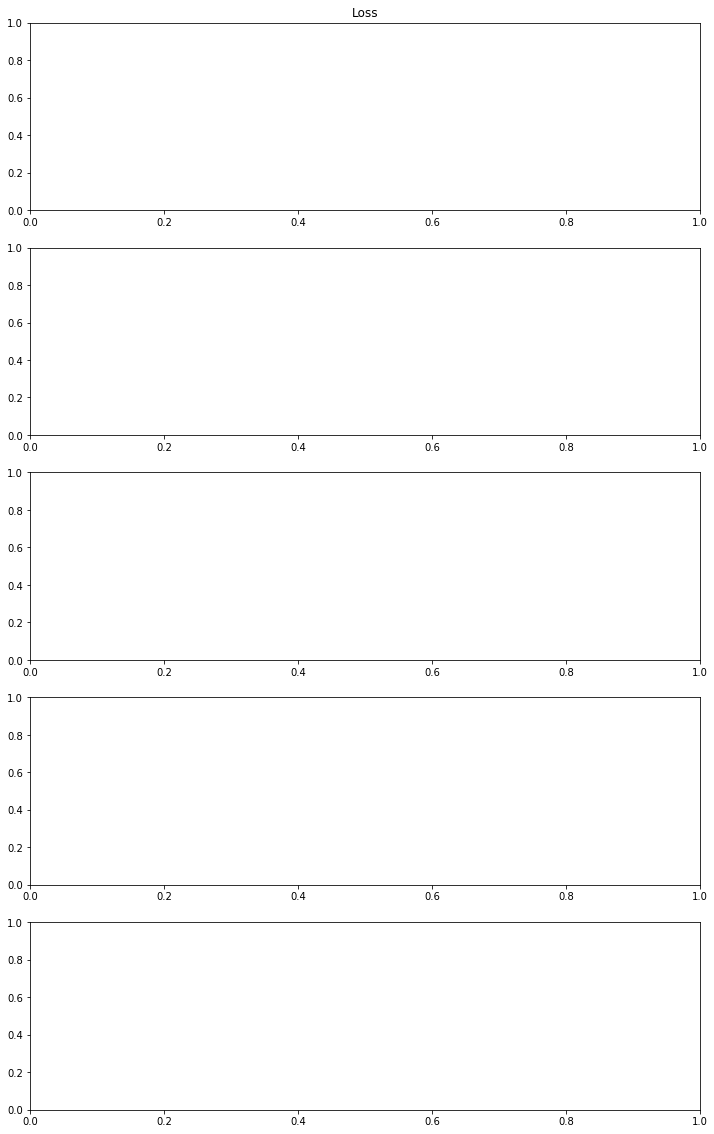

In [4]:
fig, axes = plt.subplots(5, 1, figsize=(12, 20), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Log Loss")
axes[1].plot(np.log(history.history["loss"]), c="b")
axes[1].plot(np.log(history.history["val_loss"]), c="r")

axes[2].set_title("Accuracy")
axes[2].plot(history.history["acc"], c="b")
axes[2].plot(history.history["val_acc"], c="r")

axes[3].set_title("Accuracy")
axes[3].set_ylim((0.90, 1.05))
axes[3].plot(history.history["acc"], c="b")
axes[3].plot(history.history["val_acc"], c="r")

axes[4].set_title("Log Learning Rate")
axes[4].plot(np.log(history.history["lr"]), c="b")